In [4]:
import numpy as np
import os
import sys
import cv2
import matplotlib.pyplot as plt
import open3d as o3d
%matplotlib inline 

src_path = os.path.abspath("../..")
if src_path not in sys.path:
    sys.path.append(src_path)
%load_ext autoreload
from dataset.kitti_odometry_dataset import KittiOdometryDataset, KittiOdometryDatasetConfig
from dataset.filters.filter_list import FilterList
from dataset.filters.kitti_gt_mo_filter import KittiGTMovingObjectFilter
from dataset.filters.range_filter import RangeFilter
from dataset.filters.apply_pose import ApplyPose

import scipy
from scipy.spatial.distance import cdist
from normalized_cut import normalized_cut
from ncuts_utils import ncuts_chunk,kDTree_1NN_feature_reprojection_colors, get_merge_pcds
from dataset_utils import * 
from point_cloud_utils import get_pcd, transform_pcd, kDTree_1NN_feature_reprojection, remove_isolated_points, get_subpcd, get_statistical_inlier_indices, merge_chunks_unite_instances
from aggregate_pointcloud import aggregate_pointcloud
from visualization_utils import generate_random_colors, color_pcd_by_labels,generate_random_colors_map
from sam_label_distace import sam_label_distance
from chunk_generation import subsample_positions, chunks_from_pointcloud, indices_per_patch, tarl_features_per_patch, image_based_features_per_patch, dinov2_mean, get_indices_feature_reprojection
from metrics_class import Metrics
import shutil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Here we define the dataset depending on kitti sequence!

In [5]:
DATASET_PATH = os.path.join('/media/cedric/Datasets1/semantic_kitti/')
SEQUENCE_NUM = 7

ind_start = 0
ind_end = 1100
minor_voxel_size = 0.05
major_voxel_size = 0.35
chunk_size = np.array([25, 25, 25]) #meters
overlap = 3 #meters
ground_segmentation_method = 'patchwork' 
NCUT_ground = False 
out_folder_ncuts = 'test_data/'
if os.path.exists(out_folder_ncuts):
        shutil.rmtree(out_folder_ncuts)
os.makedirs(out_folder_ncuts)

dataset = create_kitti_odometry_dataset(DATASET_PATH,SEQUENCE_NUM,ncuts_mode=True)

out_folder = 'pcd_preprocessed/'
if os.path.exists(out_folder) == False : 
        os.makedirs(out_folder)


Now we aggregate a large point cloud based on (ind_start, ind_end)
## This cell can be ignored after first run as outputs are stored 

In [3]:
'''
if os.path.exists('{out_folder}all_poses_' + str(SEQUENCE_NUM) + '_' + str(0) + '.npz') == False:
        process_and_save_point_clouds(dataset,ind_start,ind_end,minor_voxel_size=minor_voxel_size,
                                major_voxel_size=major_voxel_size,icp=False,
                                out_folder=out_folder,sequence_num=SEQUENCE_NUM,
                                ground_segmentation_method=ground_segmentation_method)
'''

"\nif os.path.exists('{out_folder}all_poses_' + str(SEQUENCE_NUM) + '_' + str(0) + '.npz') == False:\n        process_and_save_point_clouds(dataset,ind_start,ind_end,minor_voxel_size=minor_voxel_size,\n                                major_voxel_size=major_voxel_size,icp=False,\n                                out_folder=out_folder,sequence_num=SEQUENCE_NUM,\n                                ground_segmentation_method=ground_segmentation_method)\n"

This cell can be ignored after first run as outputs are stored 

In [18]:
##load data if already stored 

if os.path.exists(f'{out_folder}pcd_ground_minor.pcd') == False:
        pcd_ground_minor, pcd_nonground_minor,\
                all_poses, T_pcd, first_position,kitti_labels = load_and_downsample_point_clouds(out_folder,SEQUENCE_NUM,minor_voxel_size,\
                                                                        ground_mode=ground_segmentation_method)
        
        o3d.io.write_point_cloud(f'{out_folder}pcd_ground_minor.pcd', pcd_ground_minor, write_ascii=False, compressed=False, print_progress=False)
        o3d.io.write_point_cloud(f'{out_folder}pcd_nonground_minor.pcd', pcd_nonground_minor, write_ascii=False, compressed=False, print_progress=False)
        np.savez(f'{out_folder}kitti_labels_preprocessed.npz',panoptic_nonground=kitti_labels['panoptic_nonground'],
                                                panoptic_ground=kitti_labels['panoptic_ground'],
                                                instance_nonground=kitti_labels['instance_nonground'],
                                                instance_ground=kitti_labels['instance_ground'],
                                                seg_ground = kitti_labels['seg_ground'],
                                                seg_nonground=kitti_labels['seg_nonground']
                                                )


In [19]:
pcd_ground_minor = o3d.io.read_point_cloud(f'{out_folder}pcd_ground_minor{SEQUENCE_NUM}.pcd')
pcd_nonground_minor = o3d.io.read_point_cloud(f'{out_folder}pcd_nonground_minor{SEQUENCE_NUM}.pcd')

kitti_labels_orig = {}
with np.load(f'{out_folder}kitti_labels_preprocessed{SEQUENCE_NUM}.npz') as data :
        kitti_labels_orig['panoptic_ground'] = data['panoptic_ground']
        kitti_labels_orig['panoptic_nonground'] = data['panoptic_nonground']
        kitti_labels_orig['instance_ground'] = data['instance_ground']
        kitti_labels_orig['instance_nonground'] = data['instance_nonground']
        kitti_labels_orig['seg_nonground'] = data['seg_nonground']
        kitti_labels_orig['seg_ground'] = data['seg_ground']

        

with np.load(f'{out_folder}all_poses_{SEQUENCE_NUM}.npz') as data:
        all_poses = data['all_poses']
        T_pcd = data['T_pcd']
        first_position = T_pcd[:3, 3]

In [5]:
'''
pcd_new = o3d.geometry.PointCloud()
pts_num = 1000000
pcd_new.points = o3d.utility.Vector3dVector(np.asarray(pcd_nonground_minor.points)[:pts_num])

map_labelled = color_pcd_by_labels(pcd_new,\
                kitti_labels['panoptic_nonground'][:pts_num].reshape(-1,1))

o3d.visualization.draw_geometries([map_labelled])
#o3d.io.write_point_cloud('labelled_map07.pcd',map_labelled)
'''

"\npcd_new = o3d.geometry.PointCloud()\npts_num = 1000000\npcd_new.points = o3d.utility.Vector3dVector(np.asarray(pcd_nonground_minor.points)[:pts_num])\n\nmap_labelled = color_pcd_by_labels(pcd_new,                kitti_labels['panoptic_nonground'][:pts_num].reshape(-1,1))\n\no3d.visualization.draw_geometries([map_labelled])\n#o3d.io.write_point_cloud('labelled_map07.pcd',map_labelled)\n"

Now we subsample the poses based on a voxel_size

In [20]:
poses, positions, \
sampled_indices_local, sampled_indices_global = subsample_and_extract_positions(all_poses,ind_start=ind_start)

Now we can split the point cloud into chunks based on a tbd chunk_size

In [21]:
pcd_nonground_chunks, pcd_ground_chunks,\
pcd_nonground_chunks_major_downsampling, pcd_ground_chunks_major_downsampling, \
indices,indices_ground, center_positions, \
center_ids, chunk_bounds, kitti_labels = chunk_and_downsample_point_clouds(pcd_nonground_minor, pcd_ground_minor, T_pcd, positions, 
                                                            first_position, sampled_indices_global, chunk_size=chunk_size, 
                                                            overlap=overlap, major_voxel_size=major_voxel_size,kitti_labels=kitti_labels_orig)

Downsampled from (523285, 3) to (7646, 3) points (non-ground)
Downsampled from (257594, 3) to (5502, 3) points (ground)
Downsampled from (392323, 3) to (6659, 3) points (non-ground)
Downsampled from (273555, 3) to (4539, 3) points (ground)
Downsampled from (429859, 3) to (7470, 3) points (non-ground)
Downsampled from (291612, 3) to (6157, 3) points (ground)
Downsampled from (381642, 3) to (5813, 3) points (non-ground)
Downsampled from (255212, 3) to (4655, 3) points (ground)
Downsampled from (414475, 3) to (7677, 3) points (non-ground)
Downsampled from (237620, 3) to (4305, 3) points (ground)
Downsampled from (463157, 3) to (8880, 3) points (non-ground)
Downsampled from (226253, 3) to (5086, 3) points (ground)
Downsampled from (506123, 3) to (9688, 3) points (non-ground)
Downsampled from (228215, 3) to (4918, 3) points (ground)
Downsampled from (389712, 3) to (6633, 3) points (non-ground)
Downsampled from (308744, 3) to (4290, 3) points (ground)
Downsampled from (280190, 3) to (4670, 3

In [22]:
import sklearn
from sklearn.cluster import DBSCAN, HDBSCAN
import hdbscan

def uniform_down_sample_with_indices(points, every_k_points):
        # Create a new point cloud for the downsampled output

        # List to hold the indices of the points that are kept
        indices = []

        # Iterate over the points and keep every k-th point
        for i in range(0, points.shape[0], every_k_points):
            indices.append(i)

        return indices

def downsample_chunk(points):
        num_points_to_sample = 30000
        every_k_points = int(
            points.shape[0] /
            num_points_to_sample)
        indeces = uniform_down_sample_with_indices(
            points, every_k_points)


        return points[indeces]

def DBSCAN_clustering_logic(pcd_nonground_chunk, pcd_ground_chunk,
                        eps=0.3, min_samples=10):
    """
    Perform DBSCAN clustering on the point cloud data.

    :param cur_pcd: Current point cloud for clustering.
    :param pcd_all: All point cloud data.
    :param eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
    :param min_samples: The number of samples in a neighborhood for a point to be considered as a core point.
    :return: Cluster labels for each point in the point cloud.
    """
    
    inliers = get_statistical_inlier_indices(pcd_ground_chunk)
    ground_inliers = get_subpcd(pcd_ground_chunk, inliers)
    mean_hight = np.mean(np.asarray(ground_inliers.points)[:,2])
    in_idcs = np.where(np.asarray(ground_inliers.points)[:,2] < (mean_hight + 0.2))[0]
    cut_hight = get_subpcd(ground_inliers, in_idcs)
    cut_hight.paint_uniform_color([0, 0, 0])
    
    in_idcs = None
    
    #in_idcs = np.where(np.asarray(pcd_nonground_chunk.points)[:,2] > (mean_hight + 0.05))[0]
    #pcd_nonground_corrected = get_subpcd(pcd_nonground_chunk, in_idcs)
    pcd_nonground_corrected = pcd_nonground_chunk
    
    pcd_nonground_downsampled = o3d.geometry.PointCloud()
    pts_downsampled = downsample_chunk(np.asarray(pcd_nonground_corrected.points))
    pcd_nonground_downsampled.points = o3d.utility.Vector3dVector(pts_downsampled)
    
    clustering = DBSCAN(eps=eps, min_samples=min_samples)
    #clustering = HDBSCAN(min_cluster_size=10).fit(pts_downsampled)
    #clustering = hdbscan.HDBSCAN(algorithm='best', alpha=1., approx_min_span_tree=True,
    #                            gen_min_span_tree=True, leaf_size=100,
    #                            metric='euclidean', min_cluster_size=10, min_samples=None
    #                        )
    clustering.fit(pts_downsampled)
    
    labels_not_road = clustering.labels_
    colors_gen = generate_random_colors(500)
    
    # Reproject cluster labels to the original point cloud size
    cluster_labels = np.ones((len(pcd_nonground_corrected.points), 1)) * -1
    labels_non_ground = kDTree_1NN_feature_reprojection(cluster_labels, pcd_nonground_corrected, labels_not_road.reshape(-1,1), pcd_nonground_downsampled )
    colors = np.zeros((labels_non_ground.shape[0],3))
    unique_labels = list(np.unique(labels_non_ground))
    
    for j in unique_labels:
            cur_idcs = np.where(labels_non_ground == j)[0]
            
            colors[cur_idcs] = np.array(colors_gen[unique_labels.index(j)])
        
    pcd_nonground_corrected.colors = o3d.utility.Vector3dVector(colors / 255.)
    
    #o3d.visualization.draw_geometries([pcd_nonground_corrected])
    
    
    
    return pcd_nonground_corrected, cut_hight, in_idcs

def dbscan_clustering(pcd_chunks_major_downsampled, pcds, center_ids,ground_clouds):
    labels_clustering = []
    for i in range(len(pcd_chunks_major_downsampled)):
        cur_pcd = pcd_chunks_major_downsampled[i]
        pcd_all = pcds[i]
        ground_cloud = ground_clouds[i]
        cluster_labels = DBSCAN_clustering_logic(cur_pcd, pcd_all)  # Implement your DBSCAN logic here
        ground_labels = np.ones((np.asarray(ground_cloud.points).shape[0],1)) * -1
        cluster_labels = np.concatenate((cluster_labels,ground_labels),0)
        labels_clustering.append(cluster_labels)
        
    return labels_clustering


In [23]:
def color_pcd_by_labels(pcd, labels,colors=None,gt_labels=None):
    
    if colors == None : 
        colors = generate_random_colors(2000)
    pcd_colored = copy.deepcopy(pcd)
    pcd_colors = np.zeros(np.asarray(pcd.points).shape)
    if gt_labels is None :
    	unique_labels = list(np.unique(labels)) 
    else: 
        unique_labels = list(np.unique(gt_labels))
    
    background_color = np.array([0,0,0])


    #for i in range(len(pcd_colored.points)):
    for i in unique_labels:
        if i == -1 : 
            continue
        idcs = np.where(labels == i)
        idcs = idcs[0]
        if i == 0 : 
            pcd_colors[idcs] = background_color
        else : 
            pcd_colors[idcs] = np.array(colors[unique_labels.index(i)])
        
        #if labels[i] != (-1):
        #    pcd_colored.colors[i] = np.array(colors[labels[i]]) / 255
    pcd_colored.colors = o3d.utility.Vector3dVector(pcd_colors/ 255)
    return pcd_colored

In [24]:
alpha = 1.0
theta = 0.0
colors = generate_random_colors_map(600)
beta = 0.0
gamma = 0.5
proximity_threshold = 1.0

out_dbscan = 'out_dbscan2/'
if os.path.exists(out_dbscan) == True : 
        shutil.rmtree(out_dbscan)
        
os.makedirs(out_dbscan)

out_kitti = 'out_kitti/'
if os.path.exists(out_kitti) == True : 
        shutil.rmtree(out_kitti)

os.makedirs(out_kitti)
        
out_kitti_instance = 'out_kitti_instance2/'
if os.path.exists(out_kitti_instance) == True : 
        shutil.rmtree(out_kitti_instance)
os.makedirs(out_kitti_instance)

limit = -1 ##use this for experiments to run limit chunks numberss


patchwise_indices = indices_per_patch(T_pcd, center_positions, positions, first_position, sampled_indices_global, chunk_size)
out_data = []
for sequence in range(len(center_ids)):
                obstacle_chunk, ground_chunk, in_idcs = DBSCAN_clustering_logic(pcd_nonground_chunks[sequence],pcd_ground_chunks[sequence],
                        eps=0.4, min_samples=10)
                
                #kitti_chunk_instance = color_pcd_by_labels(obstacle_chunk,kitti_labels['nonground']['instance'][sequence][in_idcs].reshape(-1,),
                #kitti_chunk_instance = color_pcd_by_labels(obstacle_chunk,kitti_labels['nonground']['instance'][sequence].reshape(-1,),
                #                        colors=colors,gt_labels=kitti_labels_orig['instance_nonground'])
                
                #o3d.visualization.draw_geometries([kitti_chunk_instance])
                #print(kitti_chunk_instance,obstacle_chunk)
                
                name =  str(center_ids[sequence]).zfill(6) + '.pcd'
                
                o3d.io.write_point_cloud(out_dbscan + name, obstacle_chunk + ground_chunk, write_ascii=False, compressed=False, print_progress=False)
                #o3d.io.write_point_cloud(out_kitti + name, kitti_chunk + pcd_chunk_ground, write_ascii=False, compressed=False, print_progress=False)
                #o3d.io.write_point_cloud(out_kitti_instance + name, kitti_chunk_instance + ground_chunk, write_ascii=False, compressed=False, print_progress=False)
                

In [25]:
def get_merge_pcds(out_folder_ncuts):
        point_clouds = []

        # List all files in the folder
        files = os.listdir(out_folder_ncuts)
        files.sort()

        # Filter files with a .pcd extension
        pcd_files = [file for file in files if file.endswith(".pcd")]
        # Load each point cloud and append to the list
        for pcd_file in pcd_files:
                file_path = os.path.join(out_folder_ncuts, pcd_file)
                point_cloud = o3d.io.read_point_cloud(file_path)
                point_clouds.append(point_cloud)
        return point_clouds

def merge_unite_gt(chunks):
    last_chunk = chunks[0] 
    merge = o3d.geometry.PointCloud()
    merge += last_chunk

    for new_chunk in chunks[1:]:
        merge += new_chunk
    
    merge.remove_duplicated_points()
    return merge
    
def intersect(pred_indices, gt_indices):
        intersection = np.intersect1d(pred_indices, gt_indices)
        return intersection.size / pred_indices.shape[0]


def remove_semantics(labels,preds):
        gt_idcs = np.where(labels == 0)[0]
        new_ncuts_labels = preds.copy()
        for i in np.unique(preds):
                pred_idcs = np.where(preds == i)[0]
                cur_intersect = intersect(pred_idcs,gt_idcs)
                if cur_intersect > 0.8:
                        new_ncuts_labels[pred_idcs] = 0
        return new_ncuts_labels

In [16]:
out_dbscan = 'out_dbscan2/'
out_kitti_instance = 'out_kitti_instance2/'
point_clouds_dbscan = get_merge_pcds(out_dbscan)[:-1]
#point_clouds_kitti = get_merge_pcds(out_kitti)[:-1]
point_clouds_kitti_instances = get_merge_pcds(out_kitti_instance)[:-1]
#merge_kitti = merge_unite_gt(point_clouds_kitti)
merge_kitti_instance = merge_unite_gt(point_clouds_kitti_instances)
#o3d.io.write_point_cloud(out_folder + 'kitti_labels.pcd',merge_kitti_instance)
print('done')
merge_dbscan = merge_chunks_unite_instances(point_clouds_dbscan)


unique_colors, labels_dbscan = np.unique(np.asarray(merge_dbscan.colors), axis=0, return_inverse=True)
unique_colors, labels_kitti = np.unique(np.asarray(merge_kitti_instance.colors),axis=0, return_inverse=True)

new_dbscan_labels = remove_semantics(labels_kitti,labels_dbscan)
merge_instances = color_pcd_by_labels(merge_dbscan,new_dbscan_labels)



o3d.io.write_point_cloud(out_folder + 'dbscan_instances.pcd',merge_instances)


done


True

In [13]:
'''
unique_colors, labels_dbscan = np.unique(np.asarray(merge_dbscan.colors), axis=0, return_inverse=True)
unique_colors, labels_kitti = np.unique(np.asarray(merge_kitti_instance.colors),axis=0, return_inverse=True)

def intersect(pred_indices, gt_indices):
        intersection = np.intersect1d(pred_indices, gt_indices)
        return intersection.size / pred_indices.shape[0]


def remove_semantics(labels,preds):
        gt_idcs = np.where(labels == 0)[0]
        new_ncuts_labels = preds.copy()
        for i in np.unique(preds):
                pred_idcs = np.where(preds == i)[0]
                cur_intersect = intersect(pred_idcs,gt_idcs)
                if cur_intersect > 0.8:
                        new_ncuts_labels[pred_idcs] = 0
        return new_ncuts_labels

new_dbscan_labels = remove_semantics(labels_kitti,labels_dbscan)


metrics_dbscan = Metrics(name='dbscan')
metrics_test = Metrics(name='test')


metrics_dbscan.update_stats(new_dbscan_labels,labels_kitti)
#metrics_dbscan.compute_all_aps()
'''

"\nunique_colors, labels_dbscan = np.unique(np.asarray(merge_dbscan.colors), axis=0, return_inverse=True)\nunique_colors, labels_kitti = np.unique(np.asarray(merge_kitti_instance.colors),axis=0, return_inverse=True)\n\ndef intersect(pred_indices, gt_indices):\n        intersection = np.intersect1d(pred_indices, gt_indices)\n        return intersection.size / pred_indices.shape[0]\n\n\ndef remove_semantics(labels,preds):\n        gt_idcs = np.where(labels == 0)[0]\n        new_ncuts_labels = preds.copy()\n        for i in np.unique(preds):\n                pred_idcs = np.where(preds == i)[0]\n                cur_intersect = intersect(pred_idcs,gt_idcs)\n                if cur_intersect > 0.8:\n                        new_ncuts_labels[pred_idcs] = 0\n        return new_ncuts_labels\n\nnew_dbscan_labels = remove_semantics(labels_kitti,labels_dbscan)\n\n\nmetrics_dbscan = Metrics(name='dbscan')\nmetrics_test = Metrics(name='test')\n\n\nmetrics_dbscan.update_stats(new_dbscan_labels,labels_k

In [17]:
#merge_dbscan_instances = color_pcd_by_labels(merge_dbscan,new_dbscan_labels)
merge_dbscan = o3d.io.read_point_cloud(out_folder + 'dbscan_instances.pcd')
merge_kitti_instance = o3d.io.read_point_cloud(out_folder + 'kitti_labels.pcd')
o3d.visualization.draw_geometries([merge_dbscan])
o3d.visualization.draw_geometries([merge_kitti_instance])

unique_colors, labels_dbscan = np.unique(np.asarray(merge_dbscan.colors), axis=0, return_inverse=True)
unique_colors, labels_kitti = np.unique(np.asarray(merge_kitti_instance.colors),axis=0, return_inverse=True)

metrics_dbscan = Metrics(name='dbscan')

metrics_dbscan.update_stats(labels_dbscan,labels_kitti,calc_all=True)


#o3d.visualization.draw_geometries([merge_dbscan])

{'panoptic': 0.7462083706802639, 'precision': 0.8, 'recall': 0.7850467289719626, 'fScore': 0.7924528301886793, 'usr': 0.047619047619047616, 'osr': 0.009345794392523364, 'noise': 0.17142857142857143, 'missed': 0.14953271028037382, 'mean': 0.9416438963346188}
calc AP for overlap @0.25
Average Precision @ 0.25 0.713228841136625
calc AP for overlap @0.5
Average Precision @ 0.5 0.625820356332252
calc AP for overlap @0.55
Average Precision @ 0.55 0.6163387146865608
calc AP for overlap @0.6
Average Precision @ 0.6 0.5610179471608776
calc AP for overlap @0.65
Average Precision @ 0.65 0.534412397282952
calc AP for overlap @0.7
Average Precision @ 0.7 0.534412397282952
calc AP for overlap @0.75
Average Precision @ 0.75 0.5169331094928851
calc AP for overlap @0.85
Average Precision @ 0.85 0.46617196964960317
calc AP for overlap @0.9
Average Precision @ 0.9 0.421596380548742
calc AP for overlap @0.95
Average Precision @ 0.95 0.37644393819156924
AP @ 0.25 0.713228841136625
AP @ 0.5 0.62582035633225

array([0, 0, 0, ..., 0, 0, 0])

In [5]:
labels_dbscan.shape,labels_kitti.shape

((16448009,), (17182472,))

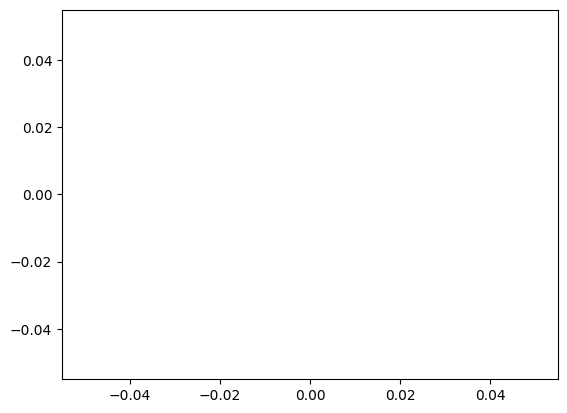

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(metrics_dbscan.recall,metrics_dbscan.precision)
plt.show()